# Маркетинговая аналитика Яндекс.Афиши


СПРИНТ 7

<a name="title"></a>
### Содержание

[Описание проекта](#info)
1. [Подготовка данных](#preprocessing)
2. [Анализ данных](#analitika)
  - [2.1. Продуктовые метрики](#by_product)
  - [2.2. Метрики электронной коммерции](#by_ecom)
  - [2.3. Маркетинговые метрики](#by_market)
3. [Общий вывод](#general)

<a name="info"></a>
# Описание проекта

**Цель**: снизить расходы

**Задача**: определить неэффективные истоники трафика.

**Данные**: Яндекс.Афиша, с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

**Изучить**:
как клиенты пользуются сервисом,
когда делают первые покупки на сайте,
сколько денег приносит компании каждый клиент,
когда расходы на привлечение клиента окупаются.

[к содержанию...](#title)

<a name="preprocessing"></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
visits = pd.read_csv('datasets/visits_log.csv')
orders = pd.read_csv('datasets/orders_log.csv')
costs = pd.read_csv('datasets/costs.csv')

## Visits

In [3]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
267792,desktop,2017-12-18 09:04:00,4,2017-12-18 09:03:00,6732076766662608086
155932,touch,2018-03-16 13:10:00,9,2018-03-16 13:09:00,9368890631967313443
275412,touch,2017-12-17 19:28:00,3,2017-12-17 19:23:00,1638266041817749747
208719,desktop,2017-06-01 14:49:00,3,2017-06-01 14:23:00,16914587377439448124
69871,desktop,2018-01-12 19:53:00,3,2018-01-12 19:44:00,6404972268507756164


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.describe(include='all')

,Device,End Ts,Source Id,Start Ts,Uid
count,359400,359400,359400.000000,359400,3.594000e+05
unique,2,224760,NaN,224303,NaN
top,desktop,2017-11-24 16:51:00,NaN,2017-11-24 16:06:00,NaN
freq,262567,23,NaN,19,NaN
mean,NaN,NaN,3.750515,NaN,9.202557e+18
std,NaN,NaN,1.917116,NaN,5.298433e+18
min,NaN,NaN,1.000000,NaN,1.186350e+13
25%,NaN,NaN,3.000000,NaN,4.613407e+18
50%,NaN,NaN,4.000000,NaN,9.227413e+18
75%,NaN,NaN,5.000000,NaN,1.372824e+19


**Произведем переименование столбцов, преобразуем форматы и добавим необходимые для дальнейшего анализа столбцы**

In [6]:
visits.columns = ['device', 'end', 'source', 'start', 'id']

In [7]:
visits.end = pd.to_datetime(visits.end)
visits.start = pd.to_datetime(visits.start)

In [8]:
visits['ses_date'] = visits.start.dt.date
visits['ses_date'] = pd.to_datetime(visits['ses_date'])
visits['ses_week'] = visits.start.dt.week
visits['ses_month'] = visits.start.dt.month
visits['ses_year'] = visits.start.dt.year

Проверим, чтобы конец сесcии не был раньше начала:

In [9]:
visits[visits['end'] < visits['start']]

,device,end,source,start,id,ses_date,ses_week,ses_month,ses_year
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-25,12,3,2018
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-25,12,3,2018


удалим данные записи...

In [10]:
visits = visits[visits['end'] >= visits['start']]

**Произведем расчет длительности сессий и оценим количество "нулевых" сессий:**

In [11]:
visits['duration'] = (visits['end'] - visits['start']).dt.seconds

In [12]:
visits.query('duration == 0').count()

device       35794
end          35794
source       35794
start        35794
id           35794
ses_date     35794
ses_week     35794
ses_month    35794
ses_year     35794
duration     35794
dtype: int64

**Несмотря на то, что количество сессий с нулевой продолжительностью достаточно велико (10%), а их природа в контексте данной работы нам неизвестна... их наличие существенно исказит расчитываемые метрики.**

**Удаляем их!**
  

In [13]:
visits = visits[visits['duration'] > 0]

In [14]:
visits.sample(5)

,device,end,source,start,id,ses_date,ses_week,ses_month,ses_year,duration
330599,desktop,2018-02-18 03:42:00,4,2018-02-18 03:18:00,15245515120710891542,2018-02-18,7,2,2018,1440
275757,desktop,2017-11-16 14:33:00,2,2017-11-16 14:29:00,5964505093346690482,2017-11-16,46,11,2017,240
198463,touch,2017-08-11 15:57:00,2,2017-08-11 15:51:00,13479532734704860216,2017-08-11,32,8,2017,360
167388,desktop,2017-10-03 12:58:00,4,2017-10-03 12:57:00,7601717970534920089,2017-10-03,40,10,2017,60
94707,desktop,2017-09-16 11:37:00,3,2017-09-16 11:30:00,3109907481835790235,2017-09-16,37,9,2017,420


In [15]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323604 entries, 0 to 359399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     323604 non-null  object        
 1   end        323604 non-null  datetime64[ns]
 2   source     323604 non-null  int64         
 3   start      323604 non-null  datetime64[ns]
 4   id         323604 non-null  uint64        
 5   ses_date   323604 non-null  datetime64[ns]
 6   ses_week   323604 non-null  int64         
 7   ses_month  323604 non-null  int64         
 8   ses_year   323604 non-null  int64         
 9   duration   323604 non-null  int64         
dtypes: datetime64[ns](3), int64(5), object(1), uint64(1)
memory usage: 27.2+ MB


## Orders

In [16]:
orders.sample(5)

,Buy Ts,Revenue,Uid
34778,2018-02-14 13:28:00,2.14,1809589866151484908
42181,2018-03-26 21:45:00,0.89,11653385808086744420
6687,2017-09-02 22:09:00,4.89,16045286664831274288
17149,2017-11-12 15:06:00,2.44,16345315694012082844
18828,2017-11-22 12:23:00,2.44,11690458316014652917


In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [18]:
orders.describe(include='all')

,Buy Ts,Revenue,Uid
count,50415,50415.000000,5.041500e+04
unique,45991,NaN,NaN
top,2018-05-31 10:13:00,NaN,NaN
freq,9,NaN,NaN
mean,NaN,4.999647,9.098161e+18
std,NaN,21.818359,5.285742e+18
min,NaN,0.000000,3.135781e+14
25%,NaN,1.220000,4.533567e+18
50%,NaN,2.500000,9.102274e+18
75%,NaN,4.890000,1.368290e+19


**Произведем переименование столбцов, преобразуем форматы и добавим необходимые для дальнейшего анализа столбцы**

In [19]:
orders.columns = ['buy', 'revenue', 'id']

In [20]:
orders.buy = pd.to_datetime(orders.buy)

In [21]:
orders['buy_date'] = orders.buy.dt.date
orders.buy_date = pd.to_datetime(orders.buy_date)

In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   buy       50415 non-null  datetime64[ns]
 1   revenue   50415 non-null  float64       
 2   id        50415 non-null  uint64        
 3   buy_date  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB


In [23]:
orders.sample(5)

,buy,revenue,id,buy_date
18882,2017-11-22 19:25:00,3.67,13888745432979765063,2017-11-22
35834,2018-02-19 23:40:00,4.89,8609126843540431759,2018-02-19
9942,2017-10-01 12:24:00,1.28,10994343720397617562,2017-10-01
43955,2018-04-13 12:09:00,4.15,3644482766749211722,2018-04-13
37376,2018-02-28 14:55:00,2.44,1347955393831469259,2018-02-28


## Costs

In [24]:
costs.sample(5)

,source_id,dt,costs
1489,5,2017-07-08,56.80
2375,10,2017-12-14,45.10
318,1,2018-04-17,48.96
2150,9,2018-05-03,8.89
1476,5,2017-06-25,70.65


In [25]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [26]:
costs.describe(include='all')

,source_id,dt,costs
count,2542.000000,2542,2542.000000
unique,NaN,364,NaN
top,NaN,2017-06-05,NaN
freq,NaN,7,NaN
mean,4.857199,NaN,129.477427
std,3.181581,NaN,156.296628
min,1.000000,NaN,0.540000
25%,2.000000,NaN,21.945000
50%,4.000000,NaN,77.295000
75%,9.000000,NaN,170.065000


**Преобразуем форматы:**

In [27]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [28]:
costs.sample(5)

,source_id,dt,costs
1503,5,2017-07-22,54.08
1724,5,2018-02-28,147.31
1039,3,2018-04-12,221.52
409,2,2017-07-17,196.68
419,2,2017-07-27,53.35


[к содержанию...](#title)

<a name="analitika"></a>
# 2. Анализ данных

<a name="by_product"></a>
## 2.1. Продуктовые метрики

### MAU

In [29]:
mau  = visits.groupby(['ses_year', 'ses_month']).agg({'id':'nunique'})
mau.mean()

id    20955.666667
dtype: float64

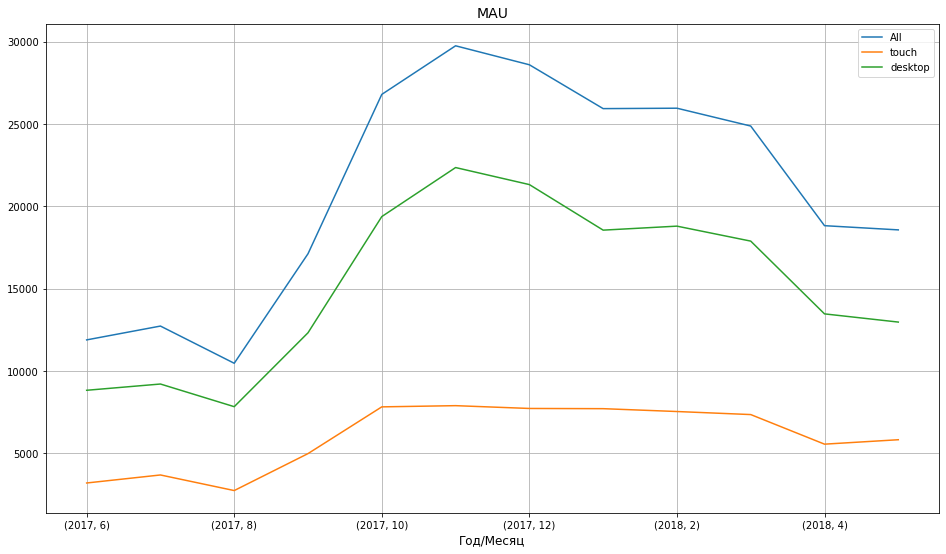

In [30]:
visits.groupby(['ses_year', 'ses_month'])['id'].nunique().plot(label='All', figsize=(16, 9))
visits.query('device == "touch"').groupby(['ses_year', 'ses_month'])['id'].nunique().plot(label='touch')
visits.query('device == "desktop"').groupby(['ses_year', 'ses_month'])['id'].nunique().plot(label='desktop')
plt.xlabel('Год/Месяц', fontsize=12)
plt.title('MAU', fontsize=14)
plt.legend()
plt.grid()
plt.show()

#### ПромВывод:
Среднее значение **MAU = 20955**, основная масса пользователей приходится на настольные системы. Наблюдается существенный рост показателя с августа 2017.

### WAU

In [31]:
wau  = visits.groupby(['ses_year', 'ses_week']).agg({'id':'nunique'})
wau.mean()

id    5148.283019
dtype: float64

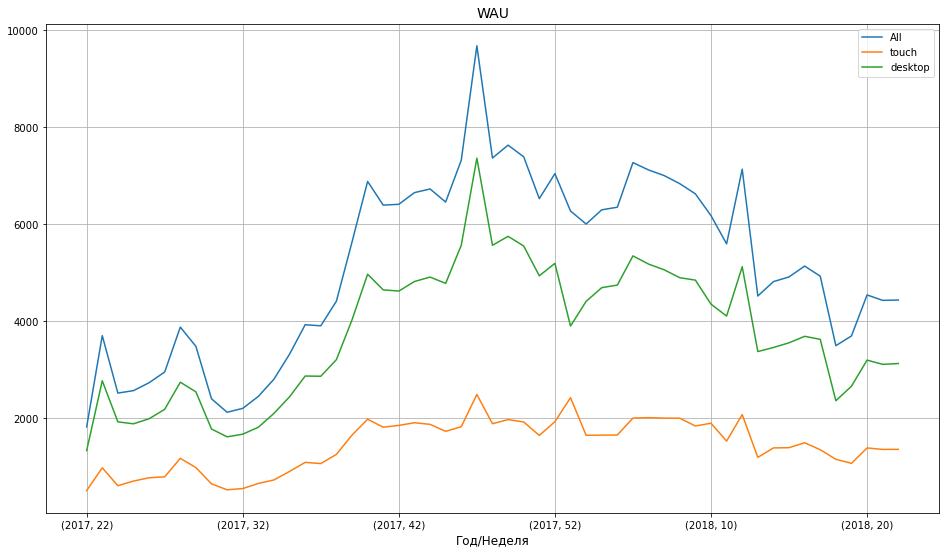

In [32]:
visits.groupby(['ses_year', 'ses_week'])['id'].nunique().plot(label='All', figsize=(16, 9))
visits.query('device == "touch"').groupby(['ses_year', 'ses_week'])['id'].nunique().plot(label='touch')
visits.query('device == "desktop"').groupby(['ses_year', 'ses_week'])['id'].nunique().plot(label='desktop')
plt.grid()
plt.xlabel('Год/Неделя', fontsize=12)
plt.title('WAU', fontsize=14)
plt.legend()
plt.show()

#### ПромВывод:
Среднее значение **WAU = 5148**, основная масса пользователей приходится на настольные системы. Наблюдается существенный рост показателя с августа 2017.

### DAU

In [33]:
dau  = visits.groupby('ses_date').agg({'id':'nunique'})
dau.mean()

id    817.582418
dtype: float64

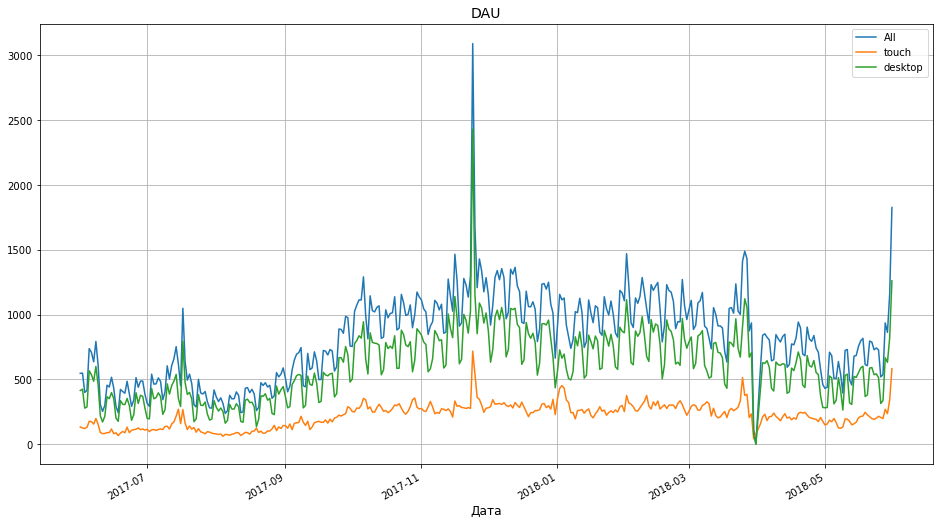

In [34]:
visits.groupby(['ses_date'])['id'].nunique().plot(label='All', figsize=(16, 9))
visits.query('device == "touch"').groupby(['ses_date'])['id'].nunique().plot(label='touch')
visits.query('device == "desktop"').groupby(['ses_date'])['id'].nunique().plot(label='desktop')
plt.grid()
plt.xlabel('Дата', fontsize=12)
plt.title('DAU', fontsize=14)
plt.legend()
plt.show()

**Зафиксируем "топовые даты":**

In [35]:
dau.sort_values(by='id', ascending=False).head(10)

,id
ses_date,
2017-11-24,3090
2018-05-31,1826
2017-11-25,1670
2018-03-26,1489
2018-02-01,1470
2017-11-16,1466
2018-03-27,1431
2017-11-27,1429
2018-03-25,1411


#### ПромВывод:
Среднее значение **DAU = 818**, основная масса польователей приходится на настольные системы. 

### Среднее количество заходов на сайт

Определим количество заходов на сайт и сохраним его в *day_count*

In [36]:
day_count  = visits.groupby('ses_date').agg({'id':['count', 'nunique']})
print('Среднее значение ежедневных заходов:', day_count.id.mean())
day_count.columns = ['n_ses', 'n_users']
day_count['ses_per_user']= day_count['n_ses'] / day_count['n_users']
day_count.reset_index()


Среднее значение ежедневных заходов: count      889.021978
nunique    817.582418
dtype: float64


,ses_date,n_ses,n_users,ses_per_user
0,2017-06-01,599,547,1.095064
1,2017-06-02,596,549,1.085610
2,2017-06-03,429,400,1.072500
3,2017-06-04,447,416,1.074519
4,2017-06-05,807,738,1.093496
...,...,...,...,...
359,2018-05-27,582,537,1.083799
360,2018-05-28,1041,936,1.112179
361,2018-05-29,942,863,1.091541
362,2018-05-30,1265,1158,1.092401


In [37]:
day_count.corr()

,n_ses,n_users,ses_per_user
n_ses,1.000000,0.998167,0.639950
n_users,0.998167,1.000000,0.608324
ses_per_user,0.639950,0.608324,1.000000


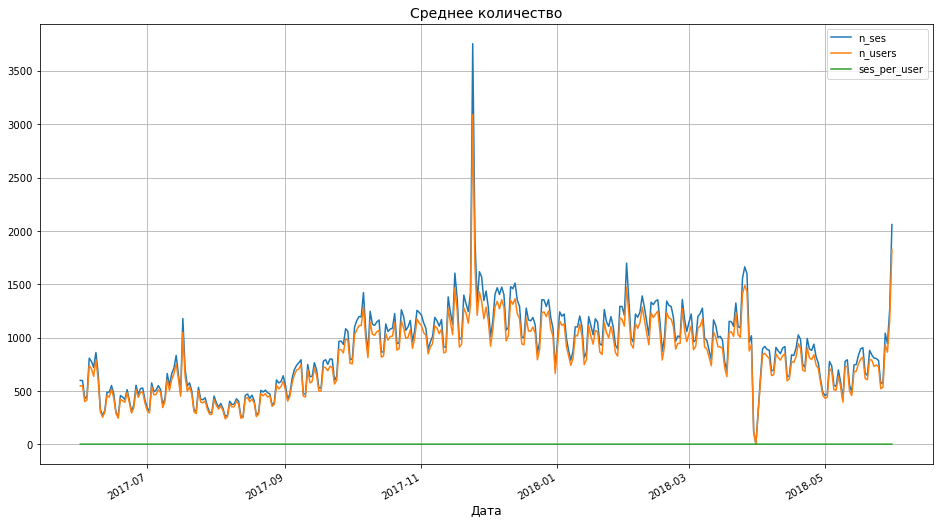

In [38]:
day_count.plot(figsize=(16, 9))
plt.grid()
plt.xlabel('Дата', fontsize=12)
plt.title('Среднее количество', fontsize=14)
plt.legend()
plt.show()

In [39]:
day_count.sort_values(by='n_users', ascending=False).head(10)

,n_ses,n_users,ses_per_user
ses_date,,,
2017-11-24,3755,3090,1.215210
2018-05-31,2059,1826,1.127601
2017-11-25,1925,1670,1.152695
2018-03-26,1663,1489,1.116857
2018-02-01,1698,1470,1.155102
2017-11-16,1604,1466,1.094134
2018-03-27,1598,1431,1.116702
2017-11-27,1617,1429,1.131561
2018-03-25,1557,1411,1.103473


**топовое количество заходов у нас приходится на вторую половину ноября 2017, конец марта 2018 и 31 мая 2018**

In [40]:
day_count.sort_values(by='n_users', ascending=True).head(20)

,n_ses,n_users,ses_per_user
ses_date,,,
2018-03-31,1,1,1.000000
2018-03-30,118,116,1.017241
2017-08-05,261,238,1.096639
2017-06-18,260,244,1.065574
2017-08-12,264,244,1.081967
2017-08-13,259,250,1.036000
2017-06-11,266,254,1.047244
2017-08-06,272,258,1.054264
2017-08-19,267,260,1.026923


#### ПромВывод:
Среднее значение **ежедневных заходов = 889**. 

Наблюдается  рост показателя с августа 2017. 

**Топовое количество заходов у нас приходится на вторую половину ноября 2017, конец марта 2018 и 31 мая 2018**.

Что-то страшное произошло 30 и 31 марта 2018... **Так же можно заметить снижение активности в летние месяцы.**

**В целом пользователи редко заходят на сайт более одного раза в день, а количество сессий четко коррелируется с количеством уникальных пользователей**

### Средняя продолжительность пользовательской сессии 

**Оценим изменение величины 'duration':**

In [41]:
visits['duration'].describe()

count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: duration, dtype: float64

**Определим моду:**

In [42]:
visits['duration'].mode()

0    60
dtype: int64

**Оценим динамику данных во времени:**

In [43]:
visits.groupby(['ses_year', 'ses_month']).agg({'duration':['mean', 'median']})

duration       
                          mean median
ses_year ses_month                   
2017     6          670.326113    360
         7          674.010817    360
         8          654.928981    300
         9          664.295180    360
         10         683.076693    360
         11         788.235180    360
         12         769.355677    360
2018     1          724.272430    360
         2          715.031060    360
         3          727.419412    360
         4          671.223505    360
         5          687.939060    360

**Срез по настольным устройствам...**

In [44]:
visits.query('device == "desktop"').groupby(['ses_year', 'ses_month']).agg({'duration':['mean', 'median']})

duration       
                          mean median
ses_year ses_month                   
2017     6          716.581758    360
         7          733.709743    360
         8          710.249671    360
         9          723.477280    420
         10         735.305153    420
         11         838.434293    420
         12         823.254717    420
2018     1          793.387177    420
         2          778.361573    420
         3          794.179555    420
         4          731.289769    360
         5          752.897470    420

In [45]:
visits.query('device == "desktop"').groupby(['ses_year', 'ses_month']).agg({'duration':['median']}).median()

duration  median    420.0
dtype: float64

**... и по мобильным:**

In [46]:
visits.query('device == "touch"').groupby(['ses_year', 'ses_month']).agg({'duration':['mean', 'median']})

duration       
                          mean median
ses_year ses_month                   
2017     6          527.436756    240
         7          508.050343    240
         8          475.513966    240
         9          500.837388    240
         10         541.694173    240
         11         633.754611    300
         12         609.328971    300
2018     1          540.386788    240
         2          537.775903    240
         3          545.089666    240
         4          504.778961    240
         5          523.953880    240

**Для наглядности отобразим медианные значения на графике**

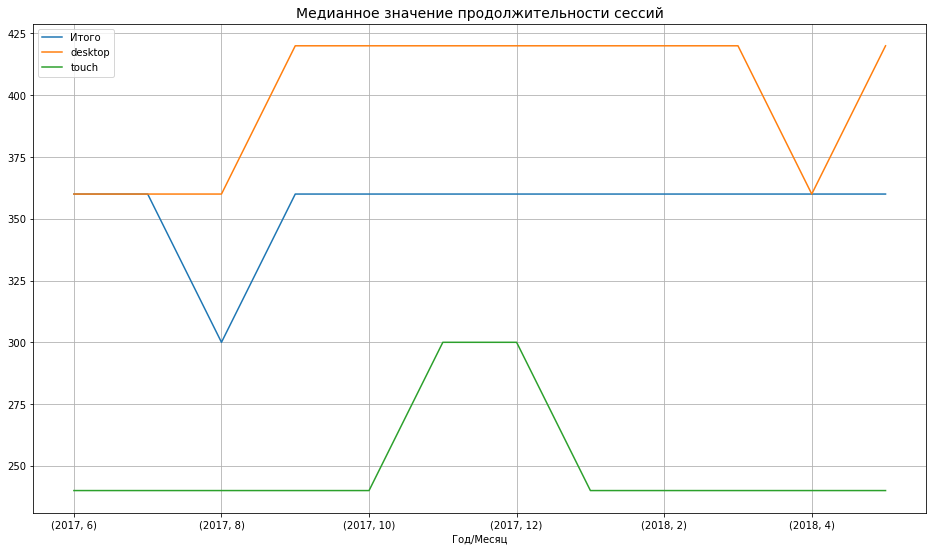

In [47]:
visits.groupby(['ses_year', 'ses_month'])['duration'].median().plot(figsize=(16, 9), label='Итого')
visits.query('device == "desktop"').groupby(['ses_year', 'ses_month'])['duration'].median().plot(label='desktop')
visits.query('device == "touch"').groupby(['ses_year', 'ses_month'])['duration'].median().plot(label='touch')
plt.title('Медианное значение продолжительности сессий', fontsize=14)
plt.xlabel('Год/Месяц')
plt.legend()
plt.grid()

**Посмотрим на самые продолжительные сессии...**

In [48]:
visits.sort_values(by = 'duration',ascending=False).head(20)

,device,end,source,start,id,ses_date,ses_week,ses_month,ses_year,duration
229891,desktop,2017-12-18 22:43:00,3,2017-12-18 10:52:00,15566184277200431914,2017-12-18,51,12,2017,42660
177381,desktop,2017-08-01 20:58:00,1,2017-08-01 11:02:00,2909927403543287328,2017-08-01,31,8,2017,35760
248062,desktop,2017-07-27 20:21:00,1,2017-07-27 11:13:00,2909927403543287328,2017-07-27,30,7,2017,32880
1197,desktop,2017-07-21 20:06:00,1,2017-07-21 11:04:00,2909927403543287328,2017-07-21,29,7,2017,32520
221945,desktop,2017-07-29 19:46:00,2,2017-07-29 11:02:00,2909927403543287328,2017-07-29,30,7,2017,31440
337996,touch,2017-11-10 00:43:00,2,2017-11-09 16:09:00,15273714129857295034,2017-11-09,45,11,2017,30840
125667,desktop,2018-03-10 22:14:00,2,2018-03-10 13:52:00,5599048030526707311,2018-03-10,10,3,2018,30120
342154,desktop,2018-01-12 18:15:00,2,2018-01-12 10:09:00,12780042542370479493,2018-01-12,2,1,2018,29160
73461,desktop,2017-07-23 19:10:00,1,2017-07-23 11:06:00,2909927403543287328,2017-07-23,29,7,2017,29040
257551,desktop,2018-02-01 17:57:00,2,2018-02-01 09:58:00,12780042542370479493,2018-02-01,5,2,2018,28740


**...и оценим распределение продолжительности, для наглядности оставим только значения менее 3000 секунд:**

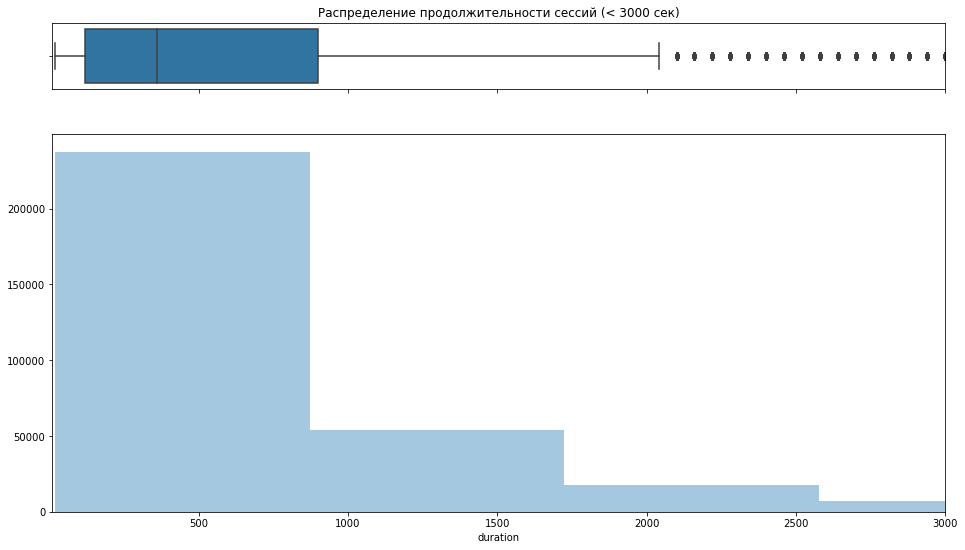

In [49]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16, 9))
plt.xlim(10, 3000)
sns.boxplot(visits['duration'], ax=ax_box)
sns.distplot(visits['duration'], ax=ax_hist, hist=True, kde=False)
ax_box.set(title='Распределение продолжительности сессий (< 3000 сек)')
ax_box.set(xlabel='')
plt.show()

#### ПромВывод:
Среднее значение времени сессии определяем по медиане: **360 сек.**, значение выше **для настольных систем - 420 сек.** и несколько ниже **для мобильных устройств - 240.** 

Время проведенное на сайте **растет в "осене-зимний" период**, логично предположим в этом специфику отрасли - выше количество мероприятий, больше времени на знакомство с ними...

 ### Retention Rate

**Произведем расчет Retention Rate, применив кагортный анализ. За временной интервал принемаем месяц:**

In [50]:
visits.groupby('id')['start'].count().sort_values()

id
11863502262781            1
11497636030843834654      1
11497731978400800633      1
11497748323206271674      1
11497793770438676642      1
                       ... 
8056418121947262981     326
17030528792926543083    349
11255648391090536411    533
3263486045884611639     579
12869801667763685675    836
Name: start, Length: 207051, dtype: int64

In [51]:
first_ses = visits.groupby(['id'])['ses_date'].min()
first_ses.name = 'first_ses_date'

In [52]:
visits = visits.join(first_ses, on='id')

In [53]:
visits['ses_month'] = visits['ses_date'].astype('datetime64[M]')
visits['first_ses_month'] = visits['first_ses_date'].astype('datetime64[M]')

In [54]:
visits['cohort_lifetime'] = visits['ses_month'] - visits['first_ses_month']
visits['cohort_lifetime'] = round(visits['cohort_lifetime'] / np.timedelta64(1,'M'), 0)
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int') 

In [55]:
cohorts = visits.groupby(['first_ses_month','cohort_lifetime']).agg({'id':'nunique'}).reset_index() 

In [56]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_ses_month','id']]
initial_users_count = initial_users_count.rename(columns={'id':'cohort_users'})

In [57]:
cohorts = cohorts.merge(initial_users_count,on='first_ses_month') 

In [58]:
cohorts['retention'] = cohorts['id']/cohorts['cohort_users']

In [59]:
retention_pivot = cohorts.pivot_table(index='first_ses_month',
                                      columns='cohort_lifetime',values='retention',aggfunc='sum') 
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_ses_month,,,,,,,,,,,,
2017-06-01,1.0,0.075726,0.050989,0.059739,0.065377,0.067480,0.057720,0.056121,0.050989,0.049727,0.038115,0.043921
2017-07-01,1.0,0.054545,0.050402,0.055645,0.056660,0.046512,0.044059,0.044059,0.037886,0.027315,0.027061,NaN
2017-08-01,1.0,0.074452,0.060451,0.060451,0.047970,0.041459,0.036249,0.037660,0.027133,0.024745,NaN,NaN
2017-09-01,1.0,0.083570,0.067769,0.049322,0.038083,0.036959,0.035372,0.022876,0.022744,NaN,NaN,NaN
2017-10-01,1.0,0.078129,0.050811,0.037811,0.033648,0.031184,0.020775,0.019798,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078183,0.042733,0.037824,0.032593,0.021729,0.020602,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.054668,0.036518,0.030178,0.019453,0.017716,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.057794,0.037817,0.024352,0.019249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.056561,0.024290,0.019184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Отобразим результат на тепловой карте:**

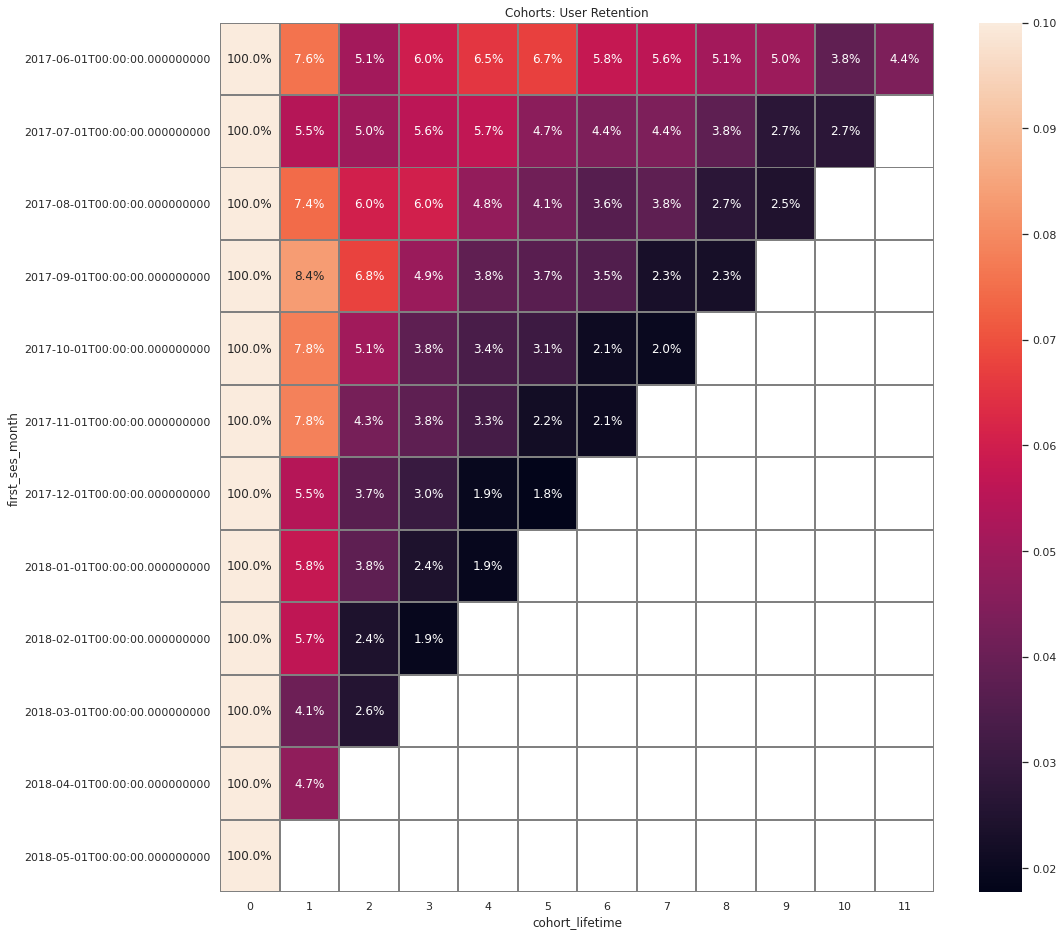

In [60]:
sns.set(style='white')
plt.figure(figsize=(16, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.10); 

#### ПромВывод:
1. Высокие показатели RR первой кагорты объясним более высокой лояльностью пользователей входящих в неё. Данная кагорта сформировалась на минимальных маркетинговых активностях и минимальных количествах пользователей отсюда и их относительно высокая вовлеченность.
2. В остальном RR перекликается и дополняет "картинку" предыдущих метрик.

### Вывод по разделу:
Среднее значение **MAU = 20955**, основная масса польователей приходится на настольные системы. Наблюдается существенный рост показателя с августа 2017.

Среднее значение **WAU = 5148**, основная масса польователей приходится на настольные системы. Наблюдается существенный рост показателя с августа 2017.

Среднее значение **DAU = 818**, основная масса польователей приходится на настольные системы. 

Среднее значение **ежедневных заходов = 889**. 

Наблюдается  рост показателя с августа 2017. 

**Топовое количество заходов у нас приходится на вторую половину ноября 2017, конец марта 2018 и 31 мая 2018**.

Что-то страшное произошло 30 и 31 марта 2018... **Так же можно заметить снижение активности в летние месяцы.**

**В целом пользователи редко заходят на сайт более одного раза в день, а количество сессий четко коррелируется с количеством уникальных пользователей**

**Среднее значение времени сессии определяем по медиане: 360 сек.**, значение выше **для настольных систем - 420 сек.** и несколько ниже **для мобильных устройств - 240.**

**Время проведенное на сайте растет в "осене-зимний" период**, логично предположим в этом специфику отрасли - выше количество мероприятий, больше времени на знакомство с ними...

#### Retention Rate:
1. Высокие показатели RR первой кагорты объясним более высокой лояльностью пользователей входящих в неё. Данная кагорта сформировалась на минимальных маркетинговых активностях и минимальных количествах пользователей отсюда и их относительно высокая вовлеченность.
2. В остальном RR перекликается и дополняет "картинку" предыдущих метрик.

[к содержанию...](#title)

<a name="by_ecom"></a>
## 2.2. Метрики электронной коммерции

### Время с момента первого посещения сайта до совершения покупки.

In [61]:
orders

,buy,revenue,id,buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31


**Добавим столбцы 'first_buy_date' определив самую ранюю дату заказа для каждого пользователя, а так же 'first_ses_date' значения которых мы определили ранее...**

In [62]:
first_buy = orders.groupby('id')['buy_date'].min()
first_buy.name = 'first_buy_date'

In [63]:
orders = orders.join(first_buy, on='id')

In [64]:
orders = orders.join(first_ses, on='id')

In [65]:
orders['time_to_buy'] = orders['first_buy_date'] - orders['first_ses_date']

**Опишем переменную:**

In [66]:
orders['time_to_buy'].describe()

count                      49941
mean     16 days 04:46:10.661380
std      45 days 08:46:50.333712
min          -328 days +00:00:00
25%              0 days 00:00:00
50%              0 days 00:00:00
75%              3 days 00:00:00
max            363 days 00:00:00
Name: time_to_buy, dtype: object

**Исключим из описания отрицательные значения, их количество и влияние невилики, а природа явно ошибочна.**

In [67]:
orders[orders['time_to_buy'] >= '0day']['time_to_buy'].describe()

count                      49456
mean     16 days 14:32:23.836945
std      45 days 03:14:33.280214
min              0 days 00:00:00
25%              0 days 00:00:00
50%              0 days 00:00:00
75%              4 days 00:00:00
max            363 days 00:00:00
Name: time_to_buy, dtype: object

#### Промежуточный вывод:

Основная масса **первых покупок происходит в день первого посещения**

### Cреднее количество покупок на одного клиента.

In [68]:
orders['buy_month'] = orders['buy_date'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')

In [69]:
orders['cohort_lifetime'] = orders['buy_month'] - orders['first_buy_month']
orders['cohort_lifetime'] = round(orders['cohort_lifetime'] / np.timedelta64(1,'M'), 0)
orders['cohort_lifetime'] = orders['cohort_lifetime'].astype('int') 
orders

,buy,revenue,id,buy_date,first_buy_date,first_ses_date,time_to_buy,buy_month,first_buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0 days,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0 days,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0 days,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0 days,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0 days,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-31,0 days,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-31,0 days,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-31,0 days,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2017-10-23,220 days,2018-05-01,2018-05-01,0


In [70]:
cohort_orders = orders.groupby(['first_buy_month', 'cohort_lifetime']).agg({'revenue':['sum','count'], 'id':'nunique'})
cohort_orders.columns = ['revenue', 'orders', 'id']
cohort_orders = cohort_orders.reset_index()

In [71]:
cohort_orders['order_per_user'] = cohort_orders['orders'] / cohort_orders['id']

In [72]:
cohort_orders

,first_buy_month,cohort_lifetime,revenue,orders,id,order_per_user
0,2017-06-01,0,9557.49,2354,2023,1.163618
1,2017-06-01,1,981.82,177,61,2.901639
2,2017-06-01,2,885.34,174,50,3.480000
3,2017-06-01,3,1931.30,226,54,4.185185
4,2017-06-01,4,2068.58,292,88,3.318182
...,...,...,...,...,...,...
74,2018-03-01,2,1114.87,176,58,3.034483
75,2018-04-01,0,10600.69,2495,2276,1.096221
76,2018-04-01,1,1209.92,195,69,2.826087
77,2018-05-01,0,13925.76,3249,2988,1.087349


In [73]:
cohort_orders['order_per_user'].mean()

1.8589644143998318

In [74]:
mean_pivot = cohort_orders.pivot_table(index='first_buy_month',
                                      columns='cohort_lifetime',values='order_per_user') 

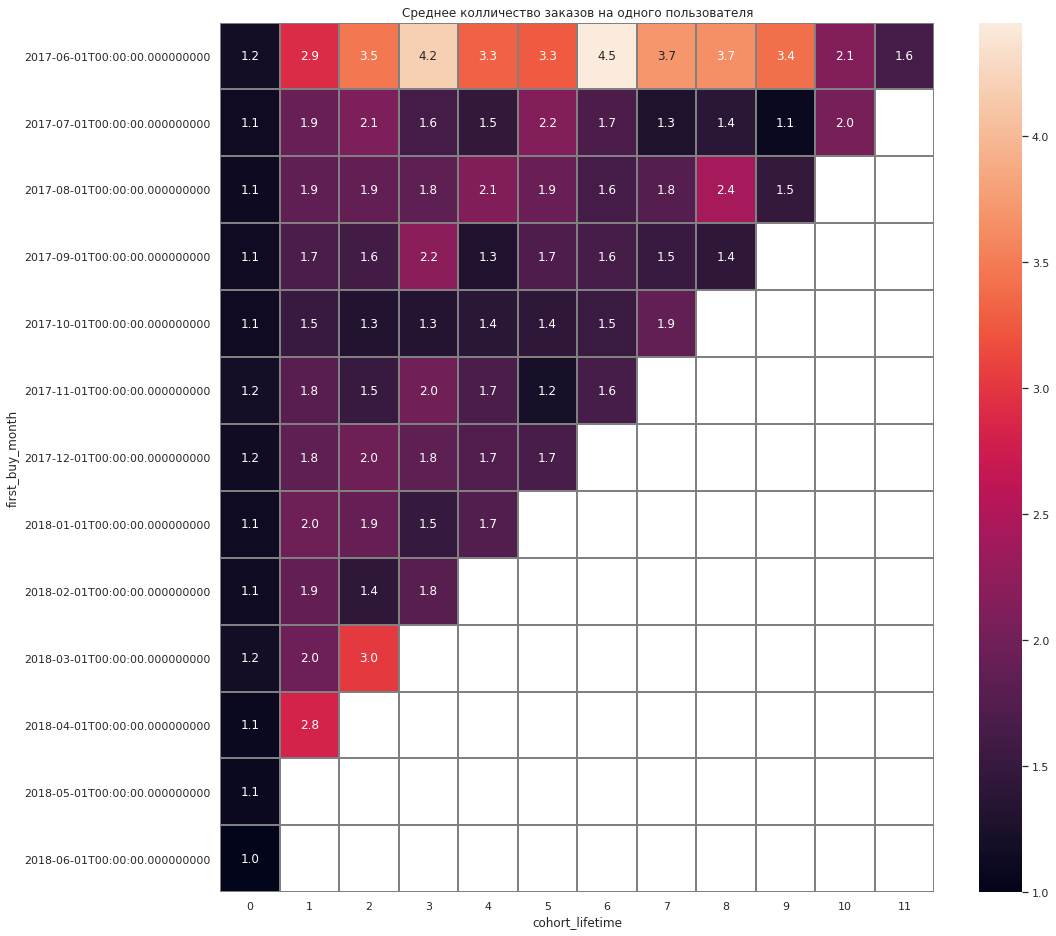

In [75]:
sns.set(style='white')
plt.figure(figsize=(16, 16))
plt.title('Среднее колличество заказов на одного пользователя')
sns.heatmap(mean_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

#### ПромВывод:
**Cреднее количество покупок на одного клиента - 1.85** данное значение существенно выше для клиентов первой кагорты, но учитывая их небольшое количество они не вносят существенных изменений в среднее

### Cредняя выручка с пользователя.

In [76]:
cohort_orders['rev_per_user'] = cohort_orders['revenue'] / cohort_orders['id']

In [77]:
cohort_orders['rev_per_user'].mean()

14.733567597262235

In [78]:
rev_pivot = cohort_orders.pivot_table(index='first_buy_month',
                                      columns='cohort_lifetime',values='rev_per_user') 

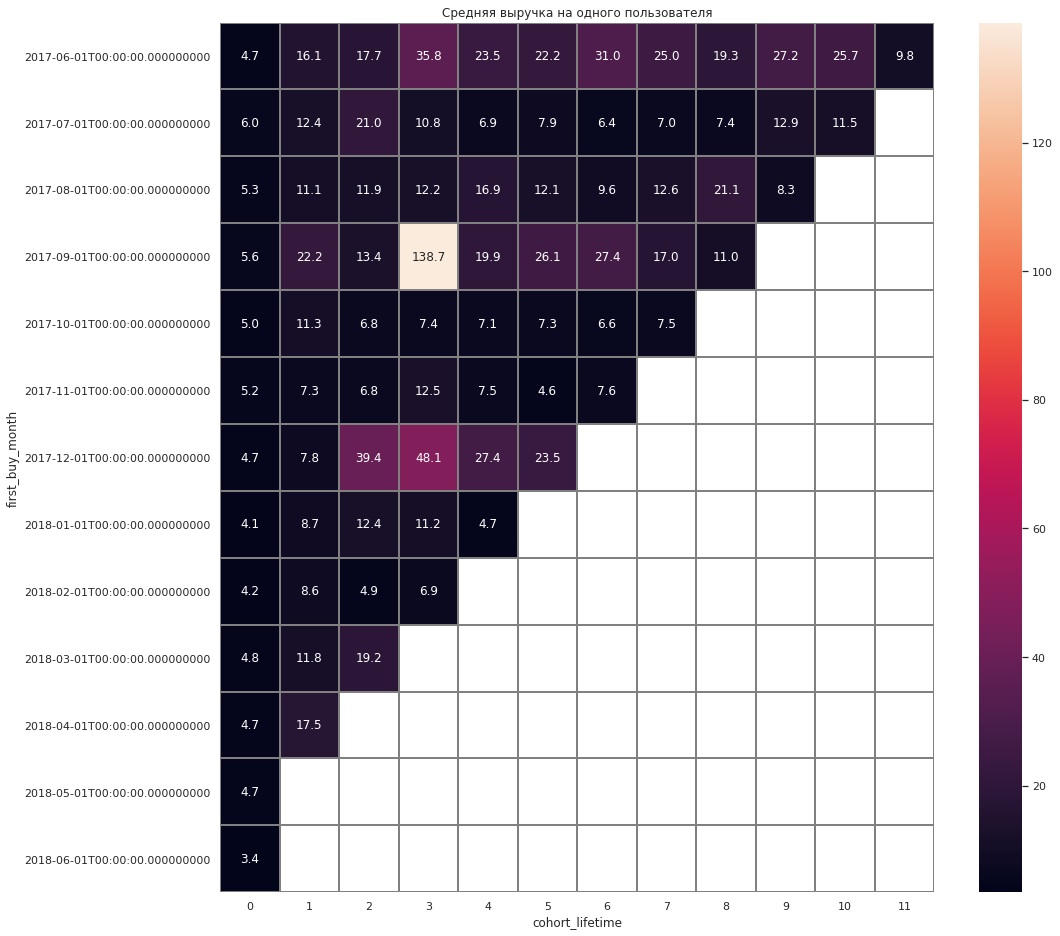

In [79]:
sns.set(style='white')
plt.figure(figsize=(16, 16))
plt.title('Средняя выручка на одного пользователя')
sns.heatmap(rev_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

**Посмотрим повнимательнее на сентябрьскую когорту в декабре:**

In [80]:
orders.query('cohort_lifetime == 3 & first_buy_month == "2017-09-01"').sort_values(by='revenue', ascending=False)

,buy,revenue,id,buy_date,first_buy_date,first_ses_date,time_to_buy,buy_month,first_buy_month,cohort_lifetime
23244,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-12-10,2017-09-20,2017-09-07,13 days,2017-12-01,2017-09-01,3
23165,2017-12-10 13:04:00,1195.64,5539673724080479777,2017-12-10,2017-09-20,2017-09-07,13 days,2017-12-01,2017-09-01,3
24341,2017-12-15 21:22:00,604.39,5539673724080479777,2017-12-15,2017-09-20,2017-09-07,13 days,2017-12-01,2017-09-01,3
21961,2017-12-05 00:50:00,402.72,5539673724080479777,2017-12-05,2017-09-20,2017-09-07,13 days,2017-12-01,2017-09-01,3
22769,2017-12-08 12:25:00,360.55,5539673724080479777,2017-12-08,2017-09-20,2017-09-07,13 days,2017-12-01,2017-09-01,3
...,...,...,...,...,...,...,...,...,...,...
21830,2017-12-04 12:51:00,0.12,15141336586528897062,2017-12-04,2017-09-19,2017-09-19,0 days,2017-12-01,2017-09-01,3
23809,2017-12-13 13:43:00,0.12,11566981771298339253,2017-12-13,2017-09-29,2017-07-13,78 days,2017-12-01,2017-09-01,3
23113,2017-12-09 23:47:00,0.03,1791615289803253802,2017-12-09,2017-09-25,2017-09-25,0 days,2017-12-01,2017-09-01,3
21504,2017-12-02 13:05:00,0.03,16118742129536584,2017-12-02,2017-09-30,2017-09-30,0 days,2017-12-01,2017-09-01,3


#### ПромВывод:
**Средняя выручка с одного пользователя составляет 14.73.** Из общей картинки выбивается сентябрьская когорта в декабре, её анализ показывает наличие крупных заказов которые искажают картику, спишем это на новогодние корпоративы.


### Накопительный LTV по когортам.

**Учитывая маржинальность сервиса 100%, для определения LTV используем сводник приготовленный для выручки.** 

Преобразуем его под условия задачи: "Сравните средний LTV по когортам за 6 месяцев. Оценивайте когорты, «прожившие» не менее 6 месяцев"

**Произведем расчет LTV и посторим его тепловую карту, затем определим накопительный LTV по кагортам 6 месяцев и старше**

In [81]:
cohort_sizes = orders.groupby('first_buy_month').agg({'id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']

In [82]:
report = pd.merge(cohort_sizes, orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index(), on='first_buy_month')

In [83]:
report['age'] = (report['buy_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

In [84]:
report

,first_buy_month,n_buyers,buy_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,0,4.660562


In [85]:
ltv_rep = report.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
ltv_rep.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


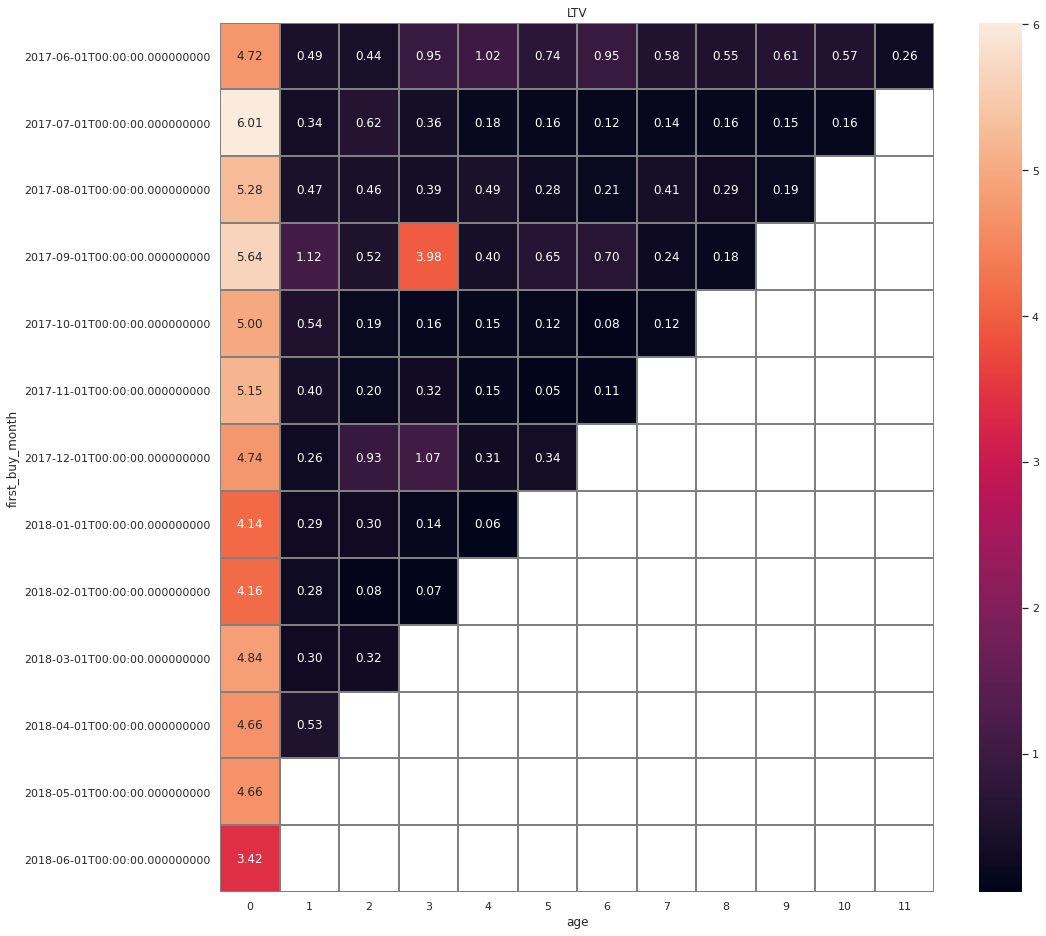

In [86]:
sns.set(style='white')
plt.figure(figsize=(16, 16))
plt.title('LTV')
sns.heatmap(ltv_rep, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

In [87]:
cumltv = ltv_rep.loc['2017-06-01':'2017-12-01', '0':'5']
cumltv['sum'] = cumltv[0]+cumltv[1]+cumltv[2]+cumltv[3]+cumltv[4]+cumltv[5]
cumltv

age,0,1,2,3,4,5,sum
first_buy_month,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,8.36
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,7.67
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,7.37
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,12.31
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,6.16
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,6.27
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,7.65


In [88]:
cumltv['sum'].mean()

7.970000000000001

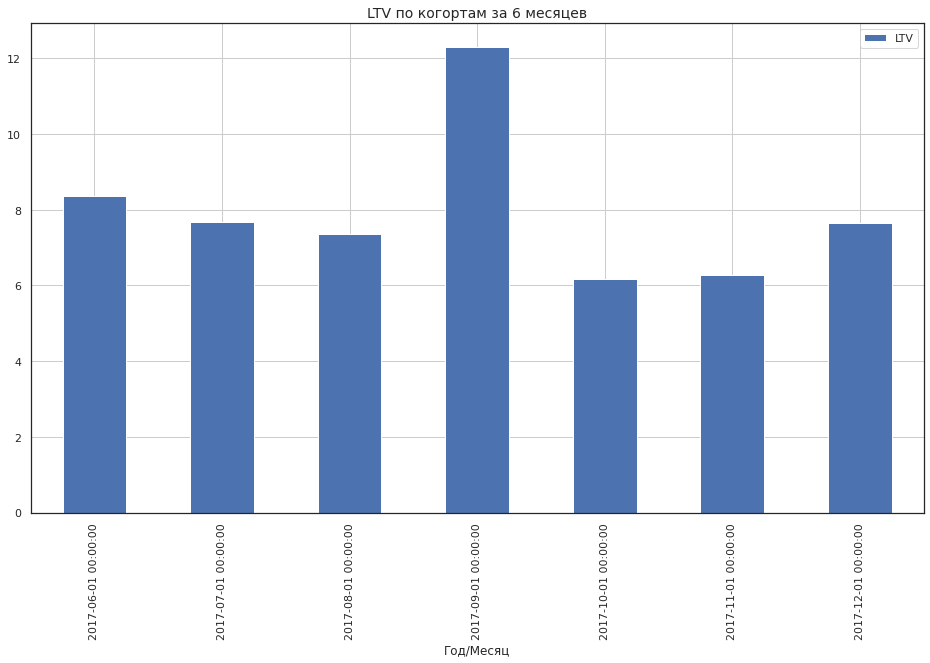

In [89]:
cumltv['sum'].plot(kind='bar', figsize=(16, 9), label='LTV')
plt.title('LTV по когортам за 6 месяцев', fontsize=14)
plt.xlabel('Год/Месяц')
plt.legend()
plt.grid()

#### ПромВывод:
**Cредний LTV за 6 месяцев - 7.97**.  (Когорты, «прожившие» не менее 6 месяцев)

[к содержанию...](#title)

<a name="by_market"></a>
## 2.3. Маркетинговые метрики

### Общая сумма расходов на маркетинг

In [90]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [91]:
costs['month'] = costs['dt'].astype('datetime64[M]')

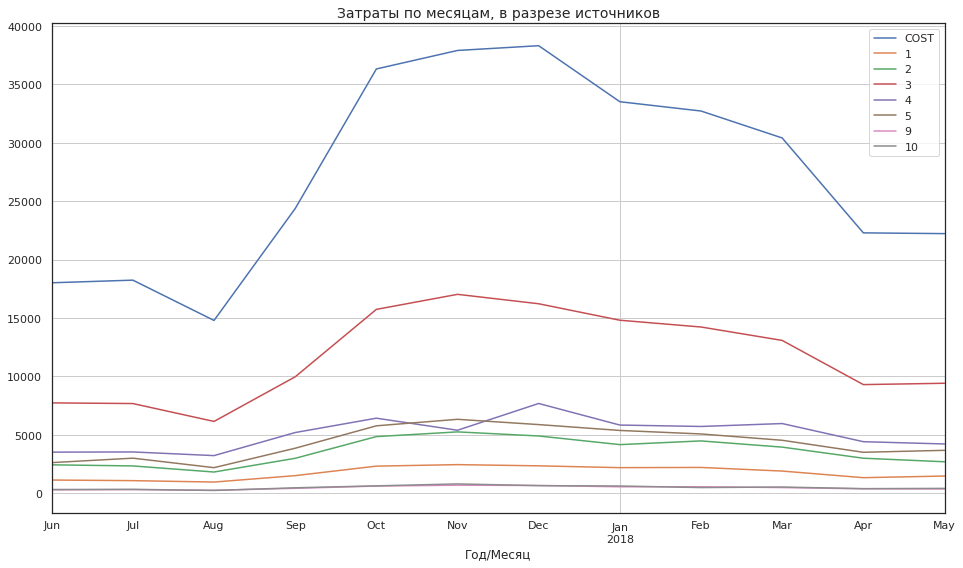

In [92]:
costs.groupby('month')['costs'].sum().plot(figsize=(16, 9), label='COST')

for i in costs.source_id.unique():
    costs[costs['source_id']==i].groupby('month')['costs'].sum().plot(label=i)
    
plt.title('Затраты по месяцам, в разрезе источников', fontsize=14)
plt.xlabel('Год/Месяц')
plt.legend()
plt.grid()

**Итого расходы за период:**

In [93]:
costs.groupby('month')['costs'].sum().sum()

329131.61999999994

#### ПромВывод:
**Маркетинговые затраты за весь период - 329 131**.  Наибольшие затраты приходятся на источник "3"

### CAC

In [94]:
first_visits = visits[['device', 'source', 'id', 'first_ses_date']]
first_visits = first_visits.drop_duplicates(subset='id', keep='first')

In [95]:
orders = orders.merge(first_visits, how='left', on='id')

In [96]:
orders.sample(5)

,buy,revenue,id,buy_date,first_buy_date,first_ses_date_x,time_to_buy,buy_month,first_buy_month,cohort_lifetime,device,source,first_ses_date_y
25617,2017-12-23 19:01:00,11.11,13777709499124655504,2017-12-23,2017-12-19,2017-12-19,0 days,2017-12-01,2017-12-01,0,desktop,2.0,2017-12-19
17010,2017-11-11 11:36:00,19.55,17342675433232643354,2017-11-11,2017-11-11,2017-11-07,4 days,2017-11-01,2017-11-01,0,touch,4.0,2017-11-07
42944,2018-04-03 16:21:00,1.40,14945705995185624396,2018-04-03,2018-04-03,2018-04-03,0 days,2018-04-01,2018-04-01,0,desktop,4.0,2018-04-03
3763,2017-07-17 21:37:00,2.44,17476756397468395632,2017-07-17,2017-07-17,2017-07-17,0 days,2017-07-01,2017-07-01,0,desktop,5.0,2017-07-17
46509,2018-05-06 17:11:00,6.11,62487689894318901,2018-05-06,2017-12-05,2017-12-05,0 days,2018-05-01,2017-12-01,5,desktop,4.0,2017-12-05


In [97]:
orders.groupby('id')['source'].nunique()

id
313578113262317         1
1575281904278712        1
2429014661409475        1
2464366381792757        1
2551852515556206        1
                       ..
18445147675727495770    0
18445407535914413204    1
18445601152732270159    1
18446156210226471712    1
18446167067214817906    1
Name: source, Length: 36523, dtype: int64

In [98]:
n_buyers = orders.groupby(['source', 'first_buy_month'])['id'].nunique()
n_buyers.name = 'n_buyers'
n_buyers = n_buyers.reset_index()
n_buyers

,source,first_buy_month,n_buyers
0,1.0,2017-06-01,202
1,1.0,2017-07-01,210
2,1.0,2017-08-01,136
3,1.0,2017-09-01,287
4,1.0,2017-10-01,409
...,...,...,...
81,10.0,2018-01-01,85
82,10.0,2018-02-01,124
83,10.0,2018-03-01,177
84,10.0,2018-04-01,106


In [99]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [100]:
costs_gr = costs.groupby(['source_id','month'])['costs'].sum().reset_index()

In [101]:
costs1 = costs_gr.merge(n_buyers, left_on=['source_id', 'month'], right_on=['source', 'first_buy_month'])


In [102]:
costs1

,source_id,month,costs,source,first_buy_month,n_buyers
0,1,2017-06-01,1125.61,1.0,2017-06-01,202
1,1,2017-07-01,1072.88,1.0,2017-07-01,210
2,1,2017-08-01,951.81,1.0,2017-08-01,136
3,1,2017-09-01,1502.01,1.0,2017-09-01,287
4,1,2017-10-01,2315.75,1.0,2017-10-01,409
...,...,...,...,...,...,...
79,10,2018-01-01,614.35,10.0,2018-01-01,85
80,10,2018-02-01,480.88,10.0,2018-02-01,124
81,10,2018-03-01,526.41,10.0,2018-03-01,177
82,10,2018-04-01,388.25,10.0,2018-04-01,106


In [103]:
costs1['cost1buyer'] = costs1['costs'] / costs1['n_buyers']
costs1

,source_id,month,costs,source,first_buy_month,n_buyers,cost1buyer
0,1,2017-06-01,1125.61,1.0,2017-06-01,202,5.572327
1,1,2017-07-01,1072.88,1.0,2017-07-01,210,5.108952
2,1,2017-08-01,951.81,1.0,2017-08-01,136,6.998603
3,1,2017-09-01,1502.01,1.0,2017-09-01,287,5.233484
4,1,2017-10-01,2315.75,1.0,2017-10-01,409,5.661980
...,...,...,...,...,...,...,...
79,10,2018-01-01,614.35,10.0,2018-01-01,85,7.227647
80,10,2018-02-01,480.88,10.0,2018-02-01,124,3.878065
81,10,2018-03-01,526.41,10.0,2018-03-01,177,2.974068
82,10,2018-04-01,388.25,10.0,2018-04-01,106,3.662736


**Рассчитаем CAC по источникам и кагортам (данные пригодятся нам позже):**

In [104]:
cac = costs1.groupby(['source_id', 'month'])['cost1buyer'].mean()
cac.name = 'cac'
cac

source_id  month     
1          2017-06-01    5.572327
           2017-07-01    5.108952
           2017-08-01    6.998603
           2017-09-01    5.233484
           2017-10-01    5.661980
                           ...   
10         2018-01-01    7.227647
           2018-02-01    3.878065
           2018-03-01    2.974068
           2018-04-01    3.662736
           2018-05-01    3.627080
Name: cac, Length: 84, dtype: float64

**и его средние во времени значения:**

In [105]:
cac_mean = costs1.groupby(['source_id'])['cost1buyer'].mean()
cac_mean.name = 'cac_mean'
cac_mean

source_id
1      5.607184
2     10.278073
3     16.026174
4      6.765427
5      7.646384
9      4.420157
10     5.287597
Name: cac_mean, dtype: float64

## ПромВывод:
**Минимальные затраты на привлечение одного пользователя имеет источник "9", максимальные "3"**

 ### ROMI
 Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт.

In [106]:
orders.sample(3)

,buy,revenue,id,buy_date,first_buy_date,first_ses_date_x,time_to_buy,buy_month,first_buy_month,cohort_lifetime,device,source,first_ses_date_y
32978,2018-02-05 02:05:00,3.36,17720912505216004162,2018-02-05,2018-02-05,2018-02-05,0 days,2018-02-01,2018-02-01,0,desktop,5.0,2018-02-05
2783,2017-07-07 14:14:00,3.05,9026543401275653811,2017-07-07,2017-07-07,2017-07-07,0 days,2017-07-01,2017-07-01,0,desktop,5.0,2017-07-07
23457,2017-12-11 22:00:00,1.71,11928872815264677503,2017-12-11,2017-12-11,2017-11-25,16 days,2017-12-01,2017-12-01,0,desktop,9.0,2017-11-25


**Произведем рассчет LTV для 7 источников трафика. Расчитываем LTV нарастающим итогом за 6 месяцев, для когорт просуществовавших 6 и более месяцев.**

In [107]:
cumltv_fin = []
for source in [ 1,  2,  3,  4, 5,  9, 10]:
    sub_df = orders[orders['source'] == source]
    cohort_sizes_s = sub_df.groupby('first_buy_month').agg({'id': 'nunique'}).reset_index()
    cohort_sizes_s.columns = ['first_buy_month', 'n_buyers']
    report_s = pd.merge(cohort_sizes_s, sub_df.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index(), on='first_buy_month')
    report_s['age'] = (report_s['buy_month'] - report_s['first_buy_month']) / np.timedelta64(1, 'M')
    report_s['age'] = report_s['age'].round().astype('int')
    report_s['ltv'] = report_s['revenue'] / report_s['n_buyers']
    ltv_rep_s = report_s.pivot_table(index='first_buy_month', columns='age', values='ltv', aggfunc='mean')
    cumltv_s = ltv_rep_s.loc['2017-06-01':'2017-12-01', '0':'5']
    cumltv_s['sum'] = cumltv_s[0]+cumltv_s[1]+cumltv_s[2]+cumltv_s[3]+cumltv_s[4]+cumltv_s[5]
    cumltv_fin.append(cumltv_s['sum'].mean())

In [108]:
cumltv_fin

[10.958176686935683,
 19.89689133979212,
 5.357071851460526,
 5.86100798896276,
 6.568326673767901,
 5.619734348279965,
 3.751015390390392]

Учитывая относительность ROMI, 100% моржинальность, а также полное соблюдение нами временных интервалов, а соответственно и количества покупателей в них, определим ROMI как отношение LTV к CAC.

Из подготовленной ранее таблицы CAC определим средний для источника CAC по первым 7 кагортам для которых произведен расчет LTV.

In [109]:
cac = cac.reset_index()
cac_7 = cac[cac['month']<'2018-01-01'].groupby('source_id')['cac'].mean()

In [110]:
cac_7

source_id
1      5.554687
2     10.073488
3     16.312151
4      7.316452
5      7.434169
9      3.678249
10     6.011653
Name: cac, dtype: float64

In [111]:
romi = cumltv_fin / cac_7
romi

source_id
1     1.972780
2     1.975174
3     0.328410
4     0.801072
5     0.883532
9     1.527828
10    0.623957
Name: cac, dtype: float64

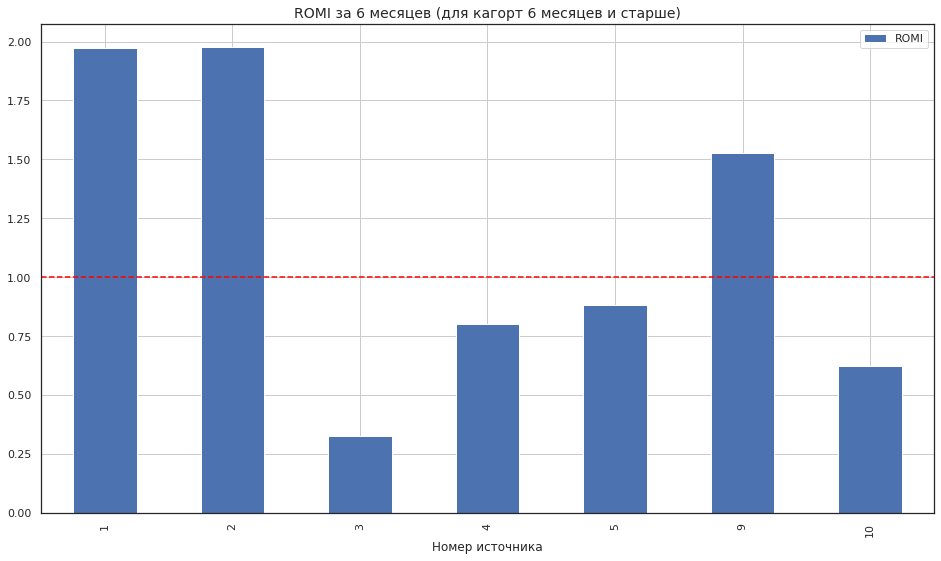

In [112]:
romi.plot(kind='bar', figsize=(16, 9), label='ROMI')
plt.title('ROMI за 6 месяцев (для кагорт 6 месяцев и старше)', fontsize=14)
plt.xlabel('Номер источника')
plt.legend()
plt.axhline(y=1, color='red', linestyle='--') 
plt.grid()

#### ПромВывод:
**Учитывая расчитанные показатели ROMI можно сделать вывод о подавляющей эффективности источников "1" и "2" и том, что на периоде 6 месяцев окупаются только источники "1", "2" и "9"**

[к содержанию...](#title)

<a name="general"></a>
# 3. Общий вывод

## Кратко перечислим полученные в ходе исследования метрики и сделанные промежуточные выводы, и резюмируем их:

### Продуктовые метрики:
Среднее значение **MAU = 20955**

Среднее значение **WAU = 5148**

Среднее значение **DAU = 818**  

Среднее значение **ежедневных заходов = 889**

Основная масса пользователей приходится на настольные системы.
Наблюдается  рост показателя с августа 2017. 

**Топовое количество заходов у нас приходится на вторую половину ноября 2017, конец марта 2018 и 31 мая 2018**.

Что-то страшное произошло 30 и 31 марта 2018... **Так же можно заметить снижение активности в летние месяцы.**

**В целом пользователи редко заходят на сайт более одного раза в день, а количество сессий четко коррелируется с количеством уникальных пользователей**

**Среднее значение времени сессии определяем по медиане: 360 сек.**, значение выше **для настольных систем - 420 сек.** и несколько ниже **для мобильных устройств - 240.**

**Время проведенное на сайте растет в "осене-зимний" период**, логично предположим в этом специфику отрасли - выше количество мероприятий, больше времени на знакомство с ними...

#### Retention Rate:
1. Высокие показатели RR первой кагорты объясним более высокой лояльностью пользователей входящих в неё. Данная кагорта сформировалась на минимальных маркетинговых активностях и минимальных количествах пользователей отсюда и их относительно высокая вовлеченность.
2. В остальном RR перекликается и дополняет "картинку" предыдущих метрик.

### Метрики электронной коммерции:

**Основная масса первых покупок происходит в день первого посещения**

**Cреднее количество покупок на одного клиента в месяц - 1.85** данное значение существенно выше для клиентов первой кагорты, но учитывая их небольшое количество они не вносят существенных изменений в среднее

**Средняя выручка с одного пользователя в месяц составляет 14.73.** Из общей картинки выбивается сентябрьская когорта в декабре, её анализ показывает наличие крупных заказов которые искажают картику, спишем это на новогодние корпоративы.

**Cредний LTV за 6 месяцев - 7.97**.  (Когорты, «прожившие» не менее 6 месяцев)


### Маркетинговые метрики:

**Маркетинговые затраты за весь период - 329 131**.  Наибольшие затраты приходятся на источник "3"

**Учитывая расчитанные показатели ROMI можно сделать вывод о подавляющей эффективности источников "1" и "2"**

**Минимальные затраты на привлечение одного пользователя имеет источник "9", максимальные "3"**


## Резюме:
1. Наиболее **эффективными** с точки зрения затрат являются **источники "1" и "2"**. Самый объемный в абсолюте **источник "3"** является и **самым дорогим с точки зрения юнит-экономики**. 
2. На периоде 6 месяцев окупаются только истоники "1", "2" и "9"
3. Основная масса **первых покупок** происходит в день **первого посещения**.
4. Наиболее **популярными устройствами** являются **настольные системы**, возможно мобильная версия недостаточно удобна (Об этом косвенно может свидетельствовать и более короткие сессии на мобильных устройствах).
5. Наиболее эффективными с точки зрения **сезонности** будут активности проведенные в **"осенне-зимний" период**. Так же данному периоду соответствует и **увеличение времени проведенного на сайте**. Кроме того имеем явное снижение активности в летние месяцы.

[к содержанию...](#title)